In [2]:
import pandas as pd
from datetime import datetime

Helper methods: 

In [27]:
def select_time_frame(metrics_data_df: pd.DataFrame, from_time: datetime, to_time: datetime, freq15s=True):
    try:
        metrics_data_df.date = metrics_data_df.date.apply(lambda datetime_str: datetime.strptime(datetime_str, '%m/%d/%Y %I:%M:%S.000000000 %p'))
    except:
        pass
    if freq15s:
        return groupby_15s(metrics_data_df[(metrics_data_df.date > from_time) & (metrics_data_df.date < to_time)], metrics_data_df.columns[-1])
    return metrics_data_df[(metrics_data_df.date > from_time) & (metrics_data_df.date < to_time)]


def select_pod_proxy_application_metrics(metrics_data_df: pd.DataFrame, pods: bool, proxies: bool, applications: bool, deucalion_sidecars: bool):
    if (pods or proxies or applications or deucalion_sidecars):
        match_strings = []
        if proxies: 
            match_strings.append('(k8s_istio-proxy)')
        if pods:
            match_strings.append('(k8s_POD)')
        if applications:
            match_strings.append('(k8s_(((?!(POD)|(istio)|(deucalion)).)))')
        if deucalion_sidecars:
            match_strings.append('(k8s_deucalion)')
        match_string = '|'.join(match_strings)
        return metrics_data_df[metrics_data_df.container_name.str.match(match_string)]
    else:
        raise Exception('no container types specified')

def print_overhead_summary(dfs, metrics_str: str, index, columns, pods: bool, proxies: bool, applications: bool, deucalion_sidecars: bool):
    data = []
    for df in dfs:
        data.append([select_pod_proxy_application_metrics(df, pods, proxies, applications, deucalion_sidecars)[metrics_str].sum() / ((df.date.iloc[-1] - df.date.iloc[0]).total_seconds()), select_pod_proxy_application_metrics(df, pods, proxies, applications, deucalion_sidecars)[metrics_str].std() / 15])
    overhead_df = pd.DataFrame(data, index, columns)
    overhead_df['pct_overhead_baseline'] = overhead_df[columns[0]].apply(lambda x: (x/overhead_df[columns[0]][[0]][0] - 1) * 100)
    display(overhead_df)
    return overhead_df

def groupby_15s(df, metrics_name):
    res = pd.DataFrame(columns=['container_name', 'date', metrics_name])
    foo = df.groupby(['container_name', pd.Grouper(key='date', freq='15s')]).sum()
    indexes = foo.index
    for index in indexes:
        res = pd.concat([res, pd.DataFrame([[index[0], index[1], foo[metrics_name][index]]], columns=['container_name', 'date', metrics_name])])
        
    return res.reset_index(drop=True)





Read data: 

In [4]:
# Without monitoring
without_monitoring_tx_bytes = pd.read_csv('data/metrics_data/without_monitoring/pods_tx_bytes.csv')
without_monitoring_rx_bytes = pd.read_csv('data/metrics_data/without_monitoring/details-pod-rx.csv')
without_monitoring_cpu = pd.read_csv('data/metrics_data/without_monitoring/details-cpu.csv')
without_monitoring_mem = pd.read_csv('data/metrics_data/without_monitoring/details-memory.csv')

# With prometheus monitoring
with_prometheus_monitoring_tx_bytes = pd.read_csv('data/metrics_data/standard_prometheus/pods_tx_bytes.csv')
with_prometheus_monitoring_rx_bytes = pd.read_csv('data/metrics_data/standard_prometheus/details-pod-rx.csv')
with_prometheus_monitoring_cpu = pd.read_csv('data/metrics_data/standard_prometheus/details-cpu.csv')
with_prometheus_monitoring_mem = pd.read_csv('data/metrics_data/standard_prometheus/details-memory.csv')

# Sidecar
sidecar_tx_bytes = pd.read_csv('data/metrics_data/sidecar/pods_tx_bytes.csv')
sidecar_rx_bytes = pd.read_csv('data/metrics_data/sidecar/details-pod-rx.csv')
sidecar_cpu = pd.read_csv('data/metrics_data/sidecar/details-cpu.csv')
sidecar_mem = pd.read_csv('data/metrics_data/sidecar/details-memory.csv')

# Federated
federated_tx_bytes = pd.read_csv('data/metrics_data/federated/pods_tx_bytes.csv')
federated_rx_bytes = pd.read_csv('data/metrics_data/federated/details-pod-rx.csv')
federated_tx_bytes_prometheus = pd.read_csv('data/metrics_data/federated/pods_tx_bytes_prometheus.csv')
federated_rx_bytes_prometheus = pd.read_csv('data/metrics_data/federated/details-pod-rx_prometheus.csv')
federated_cpu = pd.read_csv('data/metrics_data/federated/details-cpu.csv')
federated_cpu_prometheus = pd.read_csv('data/metrics_data/federated/details-cpu_prometheus.csv')
federated_mem = pd.read_csv('data/metrics_data/federated/details-memory.csv')
federated_mem_prometheus = pd.read_csv('data/metrics_data/federated/details-memory_prometheus.csv')

Select the right data on the based on timestamp: 

In [5]:
# Without monitoring
at_rest_start = datetime(2022, 5, 11, 19, 00)
at_rest_stop = datetime(2022, 5, 11, 20, 00)
without_monitoring_tx_bytes_at_rest = select_time_frame(without_monitoring_tx_bytes, at_rest_start, at_rest_stop)
without_monitoring_rx_bytes_at_rest = select_time_frame(without_monitoring_rx_bytes, at_rest_start, at_rest_stop)
without_monitoring_cpu_at_rest = select_time_frame(without_monitoring_cpu, at_rest_start, at_rest_stop)
without_monitoring_mem_at_rest = select_time_frame(without_monitoring_mem, at_rest_start, at_rest_stop)

# With prometheus monitoring
at_rest_start = datetime(2022, 5, 19, 18, 40)
at_rest_stop = datetime(2022, 5, 19, 19, 55)
with_prometheus_monitoring_tx_bytes_at_rest = select_time_frame(with_prometheus_monitoring_tx_bytes, at_rest_start, at_rest_stop)
with_prometheus_monitoring_rx_bytes_at_rest = select_time_frame(with_prometheus_monitoring_rx_bytes, at_rest_start, at_rest_stop)
with_prometheus_monitoring_cpu_at_rest = select_time_frame(with_prometheus_monitoring_cpu, at_rest_start, at_rest_stop)
with_prometheus_monitoring_mem_at_rest = select_time_frame(with_prometheus_monitoring_mem, at_rest_start, at_rest_stop)

# Sidecar
at_rest_start = datetime(2022, 5, 15, 16, 00)
at_rest_stop = datetime(2022, 5, 15, 19, 00)
sidecar_tx_bytes_at_rest = select_time_frame(sidecar_tx_bytes, at_rest_start, at_rest_stop)
sidecar_rx_bytes_at_rest = select_time_frame(sidecar_rx_bytes, at_rest_start, at_rest_stop)
sidecar_cpu_at_rest = select_time_frame(sidecar_cpu, at_rest_start, at_rest_stop)
sidecar_mem_at_rest = select_time_frame(sidecar_mem, at_rest_start, at_rest_stop)

# Federated
at_rest_start = datetime(2022, 5, 12, 22, 20)
at_rest_stop = datetime(2022, 5, 12, 22, 55)
federated_tx_bytes_at_rest = select_time_frame(federated_tx_bytes, at_rest_start, at_rest_stop)
federated_rx_bytes_at_rest =  select_time_frame(federated_rx_bytes, at_rest_start, at_rest_stop)
federated_tx_bytes_prometheus_at_rest =  select_time_frame(federated_tx_bytes_prometheus, at_rest_start, at_rest_stop)
federated_rx_bytes_prometheus_at_rest =  select_time_frame(federated_rx_bytes_prometheus, at_rest_start, at_rest_stop)
federated_cpu_at_rest =  select_time_frame(federated_cpu, at_rest_start, at_rest_stop)
federated_cpu_prometheus_at_rest =  select_time_frame(federated_cpu_prometheus, at_rest_start, at_rest_stop)
federated_mem_at_rest =  select_time_frame(federated_mem, at_rest_start, at_rest_stop)
federated_mem_prometheus_at_rest =  select_time_frame(federated_mem_prometheus, at_rest_start, at_rest_stop)

Differentiate between sidecars, pods and application metrics: 

In [6]:
# Without monitoring
without_monitoring_cpu_at_rest_proxies = select_pod_proxy_application_metrics(without_monitoring_cpu_at_rest, False, True, False, False)
without_monitoring_cpu_at_rest_apps = select_pod_proxy_application_metrics(without_monitoring_cpu_at_rest, False, False, True, False)

without_monitoring_mem_at_rest_proxies = select_pod_proxy_application_metrics(without_monitoring_mem_at_rest, False, True, False, False)
without_monitoring_mem_at_rest_apps = select_pod_proxy_application_metrics(without_monitoring_mem_at_rest, False, False, True, False)

# With prometheus monitoring
with_prometheus_monitoring_cpu_at_rest_proxies = select_pod_proxy_application_metrics(with_prometheus_monitoring_cpu_at_rest, False, True, False, False)
with_prometheus_monitoring_cpu_at_rest_apps = select_pod_proxy_application_metrics(with_prometheus_monitoring_cpu_at_rest, False, False, True, False)

with_prometheus_monitoring_mem_at_rest_proxies = select_pod_proxy_application_metrics(with_prometheus_monitoring_mem_at_rest, False, True, False, False)
with_prometheus_monitoring_mem_at_rest_apps = select_pod_proxy_application_metrics(with_prometheus_monitoring_mem_at_rest, False, False, True, False)

# Sidecar
sidecar_cpu_at_rest_proxies = select_pod_proxy_application_metrics(sidecar_cpu_at_rest, False, True, False, False)
sidecar_cpu_at_rest_apps = select_pod_proxy_application_metrics(sidecar_cpu_at_rest, False, False, True, False)
sidecar_cpu_at_rest_deucalion_sidecars = select_pod_proxy_application_metrics(sidecar_cpu_at_rest, False, False, False, True)

sidecar_mem_at_rest_proxies = select_pod_proxy_application_metrics(sidecar_mem_at_rest, False, True, False, False)
sidecar_mem_at_rest_apps = select_pod_proxy_application_metrics(sidecar_mem_at_rest, False, False, True, False)
sidecar_mem_at_rest_deucalion_sidecars = select_pod_proxy_application_metrics(sidecar_mem_at_rest, False, False, False, True)

# Federated
# TODO

### Results

application statistics: 

In [7]:
# Without monitoring
print('without monitoring')
print('mean tx bytes per second: ', without_monitoring_tx_bytes_at_rest['tx_bytes.mean_value'].mean(), 'stdev: ', without_monitoring_tx_bytes_at_rest['tx_bytes.mean_value'].std())
print('mean rx bytes per second: ', without_monitoring_rx_bytes_at_rest['rx_bytes.mean_value'].mean(), 'stdev: ', without_monitoring_rx_bytes_at_rest['rx_bytes.mean_value'].std())
print('mean cpu usage apps: ', without_monitoring_cpu_at_rest_apps['cpu_usage_total.mean_value'].mean(), 'stdev: ', without_monitoring_cpu_at_rest_apps['cpu_usage_total.mean_value'].std())
print('mean mem usage apps: ', without_monitoring_mem_at_rest_apps['memory_usage.mean_value'].mean(), 'stdev: ', without_monitoring_mem_at_rest_apps['memory_usage.mean_value'].std())

# With prometheus monitoring
print('with monitoring')
print('mean tx bytes per second: ', with_prometheus_monitoring_tx_bytes_at_rest['tx_bytes.mean_value'].mean(), 'stdev: ', with_prometheus_monitoring_tx_bytes_at_rest['tx_bytes.mean_value'].std())
print('mean rx bytes per second: ', with_prometheus_monitoring_rx_bytes_at_rest['rx_bytes.mean_value'].mean(), 'stdev: ', with_prometheus_monitoring_rx_bytes_at_rest['rx_bytes.mean_value'].std())
print('mean cpu usage apps: ', with_prometheus_monitoring_cpu_at_rest_apps['cpu_usage_total.mean_value'].mean(), 'stdev: ', with_prometheus_monitoring_cpu_at_rest_apps['cpu_usage_total.mean_value'].std())
print('mean mem usage apps: ', with_prometheus_monitoring_mem_at_rest_apps['memory_usage.mean_value'].mean(), 'stdev: ', with_prometheus_monitoring_mem_at_rest_apps['memory_usage.mean_value'].std())

# With deucalion sidecars
print('Sidecar')
print('mean tx bytes per second: ', sidecar_tx_bytes_at_rest['tx_bytes.mean_value'].mean(), 'stdev: ', sidecar_tx_bytes_at_rest['tx_bytes.mean_value'].std())
print('mean rx bytes per second: ', sidecar_rx_bytes_at_rest['rx_bytes.mean_value'].mean(), 'stdev: ', sidecar_rx_bytes_at_rest['rx_bytes.mean_value'].std())
print('mean cpu usage apps: ', sidecar_cpu_at_rest_apps['cpu_usage_total.mean_value'].mean(), 'stdev: ', sidecar_cpu_at_rest_apps['cpu_usage_total.mean_value'].std())
print('mean mem usage apps: ', sidecar_mem_at_rest_apps['memory_usage.mean_value'].mean(), 'stdev: ', sidecar_mem_at_rest_apps['memory_usage.mean_value'].std())
print('mean cpu usage deucalion: ', sidecar_cpu_at_rest_deucalion_sidecars['cpu_usage_total.mean_value'].mean(), 'stdev: ', sidecar_cpu_at_rest_deucalion_sidecars['cpu_usage_total.mean_value'].std())
print('mean mem usage deucalion: ', sidecar_mem_at_rest_deucalion_sidecars['memory_usage.mean_value'].mean(), 'stdev: ', sidecar_mem_at_rest_deucalion_sidecars['memory_usage.mean_value'].std())



without monitoring
mean tx bytes per second:  2047.2897569444444 stdev:  1457.021569998837
mean rx bytes per second:  2963.402719907407 stdev:  5632.136030464674
mean cpu usage apps:  50823251.206132635 stdev:  77455158.35899147
mean mem usage apps:  786010837.3333334 stdev:  622043483.153089
with monitoring
mean tx bytes per second:  139889.6775462963 stdev:  131256.0322821029
mean rx bytes per second:  4161.856111111111 stdev:  7438.9092803601025
mean cpu usage apps:  48184424.54897816 stdev:  75232583.46696366
mean mem usage apps:  795271650.4177778 stdev:  632262766.6377176
Sidecar
mean tx bytes per second:  2273.2824652777776 stdev:  1696.8858355945833
mean rx bytes per second:  3281.088105709877 stdev:  6595.388830483115
mean cpu usage apps:  51607445.62797182 stdev:  74347582.53259423
mean mem usage apps:  650731508.6222222 stdev:  505714745.7700148
mean cpu usage deucalion:  7554911.896581057 stdev:  8574409.64920579
mean mem usage deucalion:  220884068.5037037 stdev:  99363397

# Overhead at rest when using sidecar approach
hier zijn de nodige resultaten voor in scriptie


In [8]:
# tx bytes
print_overhead_summary([without_monitoring_tx_bytes_at_rest, with_prometheus_monitoring_tx_bytes_at_rest, sidecar_tx_bytes_at_rest, federated_tx_bytes_at_rest], 'tx_bytes.mean_value', ['without', 'with prometheus', 'deucalion sidecar', 'deucalion federated'], ['tx_bytes_per_second_mean', 'tx_bytes_per_second_std'], True, False, False, False)

,tx_bytes_per_second_mean,tx_bytes_per_second_std,pct_overhead_baseline
without,822.342329,97.134771,0.000000
with prometheus,56143.014400,8750.402152,6727.207163
deucalion sidecar,910.577677,113.125722,10.729759
deucalion federated,40709.332134,4647.604268,4850.411853


In [86]:
overhead_df['tx_bytes_per_second_mean'].iloc[0]

822.3423291492329

,tx_bytes_per_second_mean,tx_bytes_per_second_std,pct_overhead_baseline
Without monitoring,822.342329,97.134771,0.000000
Prometheus,56143.014400,8750.402152,6727.207163
Sidecar architecture,910.577677,113.125722,10.729759
Federated architecture,40709.332134,4647.604268,4850.411853


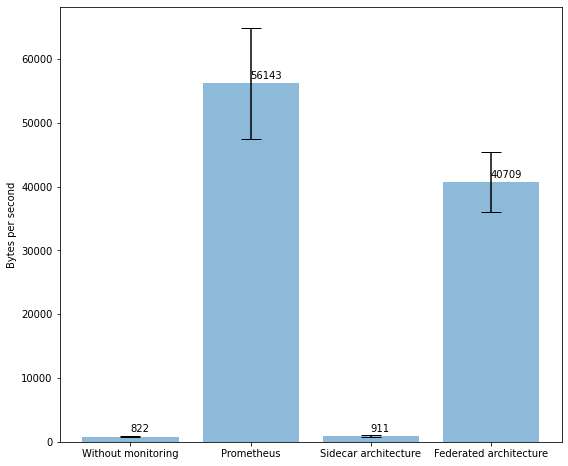

In [135]:
from matplotlib import pyplot as plt
def barplot(df, mean_str, std_str, ylabel, spacing):   
    fig, ax = plt.subplots(figsize=(9,8))
    ax.bar(df.index, mean_str, yerr=std_str, alpha=0.5, data=df, capsize=10)
    for index, row in pd.DataFrame(df[mean_str]).iterrows():
        ax.text(index, row[mean_str] + spacing, round(row[mean_str]), )
    plt.ylabel(ylabel)


tx_overhead_df = print_overhead_summary([without_monitoring_tx_bytes_at_rest, with_prometheus_monitoring_tx_bytes_at_rest, sidecar_tx_bytes_at_rest, federated_tx_bytes_at_rest], 'tx_bytes.mean_value', ['Without monitoring', 'Prometheus', 'Sidecar architecture', 'Federated architecture'], ['tx_bytes_per_second_mean', 'tx_bytes_per_second_std'], True, False, False, False)
barplot(tx_overhead_df, 'tx_bytes_per_second_mean', 'tx_bytes_per_second_std', 'Bytes per second', 700)

,rx_bytes_per_second_mean,rx_bytes_per_second_std,pct_overhead_baseline
Without monitoring,1190.320758,375.475735,0.000000
Prometheus,1670.310145,495.927285,40.324373
Sidecar architecture,1314.260604,439.692589,10.412307
Federated architecture,1530.256555,291.351834,28.558336


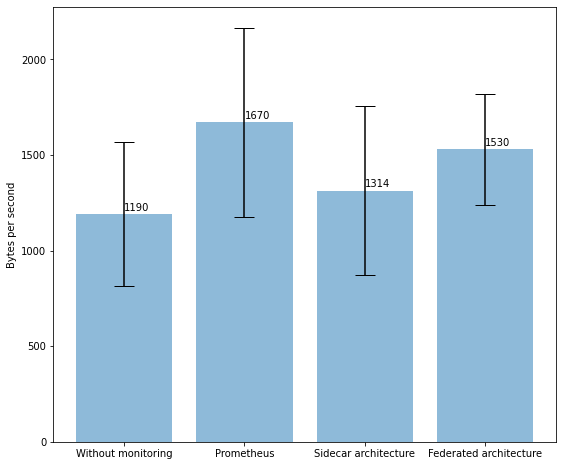

In [207]:
# rx bytes
rx_overhead_df = print_overhead_summary([without_monitoring_rx_bytes_at_rest, with_prometheus_monitoring_rx_bytes_at_rest, sidecar_rx_bytes_at_rest, federated_rx_bytes_at_rest], 'rx_bytes.mean_value', ['Without monitoring', 'Prometheus', 'Sidecar architecture', 'Federated architecture'], ['rx_bytes_per_second_mean', 'rx_bytes_per_second_std'], True, False, False, False)
barplot(rx_overhead_df, 'rx_bytes_per_second_mean', 'rx_bytes_per_second_std', 'Bytes per second', 20)

,cpu_nanoseconds_per_second_mean,cpu_nanoseconds_per_second_std,pct_overhead_baseline
Without monitoring,2.181890e+07,4.670705e+05,0.000000
Prometheus,2.420394e+07,1.210895e+06,10.931084
Sidecar architecture,2.180968e+07,9.501859e+05,-0.042237
Federated architecture,2.376646e+07,9.713155e+05,8.926020


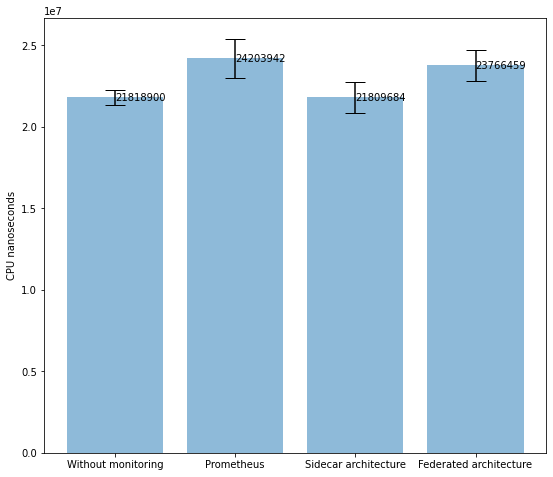

In [209]:
# cpu on proxy containers (should not increase)
proxy_cpu_overhead_df  = print_overhead_summary([without_monitoring_cpu_at_rest, with_prometheus_monitoring_cpu_at_rest, sidecar_cpu_at_rest, federated_cpu_at_rest], 'cpu_usage_total.mean_value', ['Without monitoring', 'Prometheus', 'Sidecar architecture', 'Federated architecture'], ['cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std'], False, True, False, False)

barplot(proxy_cpu_overhead_df, 'cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std', 'CPU nanoseconds', -200000)

,cpu_nanoseconds_per_second_mean,cpu_nanoseconds_per_second_std,pct_overhead_baseline
Deucalion sidecar,3.025467e+06,571627.309947,0.00000
Envoy proxy,2.181890e+07,467070.491895,621.17455


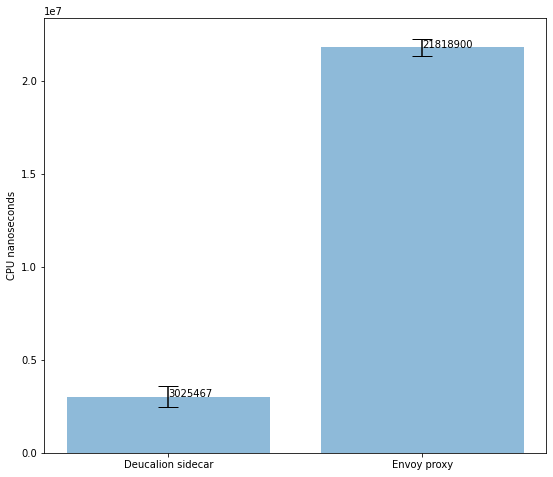

In [211]:
# CPU usage of the proxy alone to compare it to deucalion sidecars overhead
sidecar_overhead_df = print_overhead_summary([sidecar_cpu_at_rest_deucalion_sidecars, without_monitoring_cpu_at_rest_proxies], 'cpu_usage_total.mean_value', ['Deucalion sidecar', 'Envoy proxy'], ['cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std'], False, True, False, True)
barplot(sidecar_overhead_df, 'cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std', 'CPU nanoseconds', 0)


,cpu_nanoseconds_per_second_mean,cpu_nanoseconds_per_second_std,pct_overhead_baseline
Deucalion sidecar,3.025467e+06,5.716273e+05,0.000000
Envoy proxy,2.181890e+07,4.670705e+05,621.174550
applications,1.651937e+07,5.163677e+06,446.010678


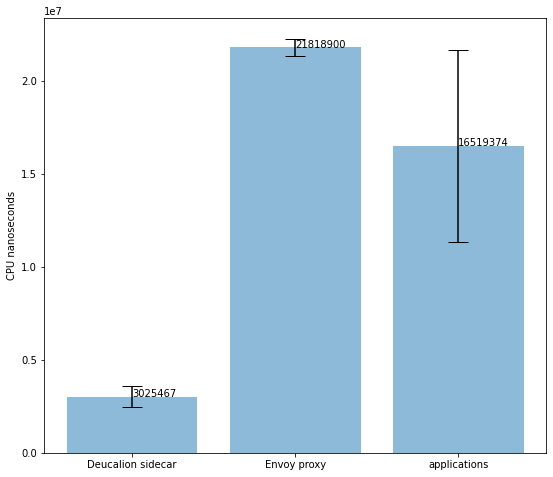

In [245]:
sidecar_overhead_df = print_overhead_summary([sidecar_cpu_at_rest_deucalion_sidecars, without_monitoring_cpu_at_rest_proxies, without_monitoring_cpu_at_rest_apps], 'cpu_usage_total.mean_value', ['Deucalion sidecar', 'Envoy proxy', 'applications'], ['cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std'], False, True, True, True)
barplot(sidecar_overhead_df, 'cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std', 'CPU nanoseconds', 0)


# CPU overhead only sidecars
print_overhead_summary([without_monitoring_cpu_at_rest, with_prometheus_monitoring_cpu_at_rest, sidecar_cpu_at_rest], 'cpu_usage_total.mean_value', ['without', 'with prometheus', 'deucalion sidecar'], ['cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std'], False, False, False, True)

In [12]:
# federated cpu overhead 
federated_cpu_prometheus_at_rest = federated_cpu_prometheus_at_rest[federated_cpu_prometheus_at_rest.container_name.str.match('(k8s_deucalion)|(k8s_prometheus-server_)')]
print_overhead_summary([select_pod_proxy_application_metrics(federated_cpu_prometheus_at_rest, False, False, True, False), select_pod_proxy_application_metrics(federated_cpu_prometheus_at_rest, False, False, True, True)], 'cpu_usage_total.mean_value', ['prometheus server', 'with deucalion sidecar'], ['cpu_usage_mean', 'cpu_usage_std'], False, True, True, True)

,cpu_usage_mean,cpu_usage_std,pct_overhead_baseline
prometheus server,8.038641e+06,1.686181e+06,0.0000
with deucalion sidecar,1.049463e+07,1.871442e+06,30.5523


In [140]:
# memory
def groupby_15s_mean(df, metrics_name):
    res = pd.DataFrame(columns=['container_name', 'date', metrics_name])
    foo = df.groupby(['container_name', pd.Grouper(key='date', freq='15s')]).mean()
    indexes = foo.index
    for index in indexes:
        res = pd.concat([res, pd.DataFrame([[index[0], index[1], foo[metrics_name][index]]], columns=['container_name', 'date', metrics_name])])
        
    return res.reset_index(drop=True)

def select_time_frame_mean(metrics_data_df: pd.DataFrame, from_time: datetime, to_time: datetime, freq15s=True):
    try:
        metrics_data_df.date = metrics_data_df.date.apply(lambda datetime_str: datetime.strptime(datetime_str, '%m/%d/%Y %I:%M:%S.000000000 %p'))
    except:
        pass
    if freq15s:
        return groupby_15s_mean(metrics_data_df[(metrics_data_df.date > from_time) & (metrics_data_df.date < to_time)], metrics_data_df.columns[-1])
    return metrics_data_df[(metrics_data_df.date > from_time) & (metrics_data_df.date < to_time)]


sidecar_memory_at_rest_between = select_time_frame_mean(sidecar_mem, datetime(2022, 5, 15, 20, 20), datetime(2022, 5, 15, 21, 30))
print('mean memory usage for deucalion sidecars', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, False, True).mean())
print('mean memory usage for proxies', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, True, False, False).mean())


mean memory usage for deucalion sidecars memory_usage.mean_value    7.055307e+07
dtype: float64
mean memory usage for proxies memory_usage.mean_value    5.140233e+07
dtype: float64


<ipython-input-140-95dfab501cae>:22: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print('mean memory usage for deucalion sidecars', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, False, True).mean())
<ipython-input-140-95dfab501cae>:23: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print('mean memory usage for proxies', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, True, False, False).mean())


In [142]:
print('mean memory usage for deucalion sidecars', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, False, True)['memory_usage.mean_value'].mean())
print('std memory usage for deucalion sidecars', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, False, True)['memory_usage.mean_value'].std())
print('mean memory usage for proxies', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, True, False, False)['memory_usage.mean_value'].mean())
print('mean memory usage for proxies', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, True, False, False)['memory_usage.mean_value'].std())
print('mean memory usage for applications', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, True, False)['memory_usage.mean_value'].mean())
print('mean memory usage for applications', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, True, False)['memory_usage.mean_value'].std())


mean memory usage for deucalion sidecars 70553074.42338385
std memory usage for deucalion sidecars 6858055.224012795
mean memory usage for proxies 51402333.63824916
mean memory usage for proxies 1913828.2150184368
mean memory usage for applications 106081316.61575757
mean memory usage for applications 51652058.94538798
memory_usage.mean_value    7.055307e+07
dtype: float64
date                       0 days 00:20:12.788835690
memory_usage.mean_value               6858055.224013
dtype: object


<ipython-input-142-3301ee43b579>:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, False, True).mean())


In [144]:
select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, True, False).groupby('container_name').describe()

memory_usage.mean_value  \
                                                                     count   
container_name                                                               
k8s_details_details-v1-994cb687f-p5wrv_sidecar_...                   101.0   
k8s_productpage_productpage-v1-6c575bc5f7-n9mzs...                   280.0   
k8s_ratings_ratings-v1-7669f78ff5-8bq5g_sidecar...                    99.0   
k8s_reviews_reviews-v1-d9c7bcb7f-vhh6s_sidecar_...                   280.0   
k8s_reviews_reviews-v2-7848469667-w6kxk_sidecar...                   280.0   
k8s_reviews_reviews-v3-5b4bcdbdff-2j22g_sidecar...                   280.0   

                                                                  \
                                                            mean   
container_name                                                     
k8s_details_details-v1-994cb687f-p5wrv_sidecar_...  1.960755e+07   
k8s_productpage_productpage-v1-6c575bc5f7-n9mzs...  5.944115e+07   
k8s_ratings_ratings-v1-7669f78ff5-8bq5g_sidecar...  1.018266e+07   
k8s_reviews_reviews-v1-d9c7bcb7f-vhh6s_sidecar_...  1.299538e+08   
k8s_reviews_reviews-v2-7848469667-w6kxk_sidecar...  1.474249e+08   
k8s_reviews_reviews-v3-5b4bcdbdff-2j22g_sidecar...  1.526047e+08   

                                                                               \
                                                             std          min   
container_name                                                                  
k8s_details_details-v1-994cb687f-p5wrv_sidecar_...      0.000000   19607552.0   
k8s_productpage_productpage-v1-6c575bc5f7-n9mzs...      0.000000   59441152.0   
k8s_ratings_ratings-v1-7669f78ff5-8bq5g_sidecar...      0.000000   10182656.0   
k8s_reviews_reviews-v1-d9c7bcb7f-vhh6s_sidecar_...      0.000000  129953792.0   
k8s_reviews_reviews-v2-7848469667-w6kxk_sidecar...  33528.705483  147402752.0   
k8s_reviews_reviews-v3-5b4bcdbdff-2j22g_sidecar...   5874.787661  152600576.0   

                                                                              \
                                                            25%          50%   
container_name                                                                 
k8s_details_details-v1-994cb687f-p5wrv_sidecar_...   19607552.0   19607552.0   
k8s_productpage_productpage-v1-6c575bc5f7-n9mzs...   59441152.0   59441152.0   
k8s_ratings_ratings-v1-7669f78ff5-8bq5g_sidecar...   10182656.0   10182656.0   
k8s_reviews_reviews-v1-d9c7bcb7f-vhh6s_sidecar_...  129953792.0  129953792.0   
k8s_reviews_reviews-v2-7848469667-w6kxk_sidecar...  147402752.0  147431424.0   
k8s_reviews_reviews-v3-5b4bcdbdff-2j22g_sidecar...  152600576.0  152600576.0   

                                                                               
                                                            75%           max  
container_name                                                                 
k8s_details_details-v1-994cb687f-p5wrv_sidecar_...   19607552.0  1.960755e+07  
k8s_productpage_productpage-v1-6c575bc5f7-n9mzs...   59441152.0  5.944115e+07  
k8s_ratings_ratings-v1-7669f78ff5-8bq5g_sidecar...   10182656.0  1.018266e+07  
k8s_reviews_reviews-v1-d9c7bcb7f-vhh6s_sidecar_...  129953792.0  1.299538e+08  
k8s_reviews_reviews-v2-7848469667-w6kxk_sidecar...  147431424.0  1.478833e+08  
k8s_reviews_reviews-v3-5b4bcdbdff-2j22g_sidecar...  152612864.0  1.526211e+08

# Load tests

In [15]:
import os
import re
def read_load_test_data(dir: str, match_pattern: str):
    files = os.listdir(dir)
    pattern = re.compile(match_pattern)
    res = {}
    for filename in files:
        match = re.match(pattern, filename)
        if match:
            with open(dir + '/' + filename) as file:
                lines = file.readlines()
                starttime = datetime.fromtimestamp(int(lines[1].split(',')[0]))
                stoptime = datetime.fromtimestamp(int(lines[-1].split(',')[0]))
                res[match.group(1)] = {}
                res[match.group(1)]['timeframe'] = (starttime, stoptime)

                latency_data = {}
                rqsps_data = {}
                for line in lines[1:]:
                    timestamp = datetime.fromtimestamp(int(line.split(',')[0]))
                    reqspersec = float(line.split(',')[4])
                    rqsps_data[timestamp] = reqspersec
                res[match.group(1)]['rqsps'] = rqsps_data
    return res

def get_metrics_data_for_load_tests(requests_data, metrics_data):
    metrics_data_for_load_test = {}
    for loadtest_nr in requests_data:
        start_time, stop_time = requests_data[loadtest_nr]['timeframe']
        metrics_data_for_load_test[loadtest_nr] = select_time_frame(metrics_data, start_time, stop_time, False)

    return metrics_data_for_load_test

def get_tx_bytes_vs_rqsps(requestsdata, metricsdata):
    result = None
    for loadtestnr in requestsdata:
        foo = pd.DataFrame.from_dict(requestsdata[loadtestnr]['rqsps'], orient='index').reset_index().rename(columns={'index': 'date', 0: 'rqsps'}).join(metricsdata[loadtestnr].groupby('date').sum(), on='date', how='inner')
        if result is None:
            result = foo
        else:
            result = pd.concat([result, foo])
    result.rqsps = result.rqsps.round(-1)
    return result[result.rqsps <= 80].groupby('rqsps').mean()


In [16]:
# without monitoring
without_monitoring_load_test_requests_data = read_load_test_data('data/requests_data/without_monitoring', 'withoutmonitoringloadtest([1-7])_stats_history.csv')
without_monitoring_load_test_metrics_data = get_metrics_data_for_load_tests(without_monitoring_load_test_requests_data, without_monitoring_tx_bytes)

# standard monitoring
with_prometheus_monitoring_load_test_requests_data = read_load_test_data('data/requests_data/standard_prometheus', 'standardprometheusloadtest([1-7])_stats_history.csv')
with_prometheus_monitoring_load_test_metrics_data = get_metrics_data_for_load_tests(with_prometheus_monitoring_load_test_requests_data, with_prometheus_monitoring_tx_bytes)

# sidecar
sidecar_load_test_requests_data = read_load_test_data('data/requests_data/sidecar', 'sidecarloadtest([1-7])_stats_history.csv')
sidecar_load_test_metrics_data = get_metrics_data_for_load_tests(sidecar_load_test_requests_data, sidecar_tx_bytes)

# federated
federated_load_test_requests_data = read_load_test_data('data/requests_data/federated', 'federatedloadtest([1-7])_stats_history.csv')
federated_load_test_metrics_data = get_metrics_data_for_load_tests(federated_load_test_requests_data, federated_tx_bytes)


In [17]:
federated_load_test_metrics_data['1'].container_name.unique()

array(['k8s_POD_details-v1-6b57d5cfc5-vkprm_federated_c0d05e9b-acfd-4f23-b908-b115913872bd_0',
       'k8s_POD_productpage-v1-55ccf4df89-fjx8z_federated_db579448-ffee-4881-9438-8e595993154e_0',
       'k8s_POD_ratings-v1-7dd4d9574-8qgzx_federated_87a036c2-ed1c-42c7-97f4-15dbe5677858_0',
       'k8s_POD_reviews-v2-698c5d7d5d-2hlfb_federated_d3a21cf9-a85f-46ef-915a-b2d342c25c69_0',
       'k8s_POD_reviews-v3-57754b8cd8-rzr7g_federated_598eaf70-1fd0-4f2a-8c0b-012a421beda1_0',
       'k8s_POD_reviews-v1-c95c59f68-wbn6z_federated_8936629c-d6ef-427e-88f2-cf880b38c0df_0'],
      dtype=object)

<AxesSubplot:xlabel='rqsps'>

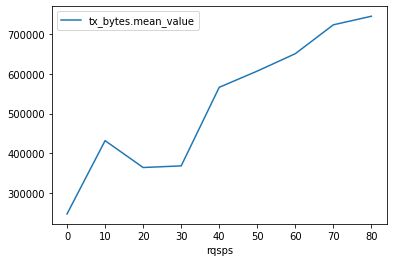

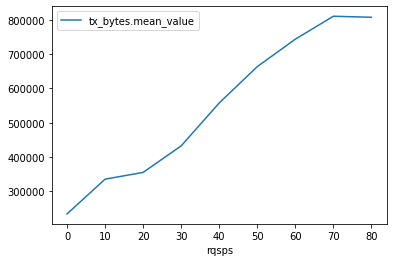

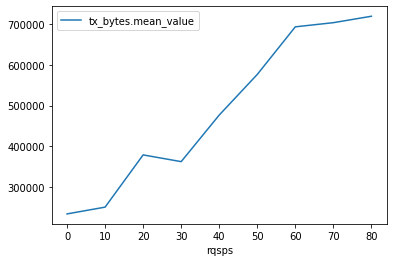

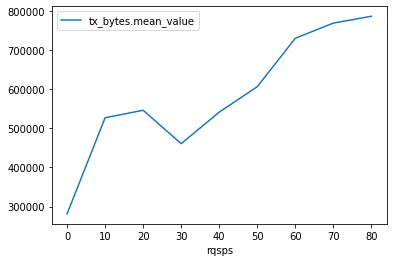

In [18]:
without_monitoring_load_test_data = get_tx_bytes_vs_rqsps(without_monitoring_load_test_requests_data, without_monitoring_load_test_metrics_data)
with_prometheus_monitoring_load_test_data = get_tx_bytes_vs_rqsps(with_prometheus_monitoring_load_test_requests_data, with_prometheus_monitoring_load_test_metrics_data)
sidecar_load_test_data = get_tx_bytes_vs_rqsps(sidecar_load_test_requests_data, sidecar_load_test_metrics_data)
federated_load_test_data = get_tx_bytes_vs_rqsps(federated_load_test_requests_data, federated_load_test_metrics_data)

without_monitoring_load_test_data.plot()
with_prometheus_monitoring_load_test_data.plot()
sidecar_load_test_data.plot()
federated_load_test_data.plot()

In [221]:
def mean_max_reqsps(requests_data_dict):
    maxes = []
    for foo in requests_data_dict:
        maxes.append(pd.DataFrame.from_dict(requests_data_dict[foo]['rqsps'], orient='index')[0].max())
    bar = pd.DataFrame(maxes)
    return bar[0].mean(), bar[0].std(), bar[0].max()


print(mean_max_reqsps(without_monitoring_load_test_requests_data))
print(mean_max_reqsps(with_prometheus_monitoring_load_test_requests_data))
print(mean_max_reqsps(sidecar_load_test_requests_data))
print(mean_max_reqsps(federated_load_test_requests_data))



(82.1, 2.335594142825331, 86.1)
(81.05999999999999, 0.2073644135332764, 81.3)
(81.32000000000001, 0.1788854381999845, 81.5)
(81.0, 0.6429100507328617, 82.3)


In [227]:
load_test = pd.DataFrame.from_dict({'Without monitoring': \
    [mean_max_reqsps(without_monitoring_load_test_requests_data)[0],
     mean_max_reqsps(without_monitoring_load_test_requests_data)[1],
     mean_max_reqsps(without_monitoring_load_test_requests_data)[2]],
    'Prometheus': [
        mean_max_reqsps(with_prometheus_monitoring_load_test_requests_data)[0],
        mean_max_reqsps(with_prometheus_monitoring_load_test_requests_data)[1],
        mean_max_reqsps(with_prometheus_monitoring_load_test_requests_data)[2]
    ],
    'Sidecar architecture': [mean_max_reqsps(sidecar_load_test_requests_data)[0], mean_max_reqsps(sidecar_load_test_requests_data)[1], mean_max_reqsps(sidecar_load_test_requests_data)[2]],
    'Federated architecture': [mean_max_reqsps(federated_load_test_requests_data)[0], mean_max_reqsps(federated_load_test_requests_data)[1],mean_max_reqsps(federated_load_test_requests_data)[2]]
    }, columns=['mean', 'std', 'max'], orient='index')




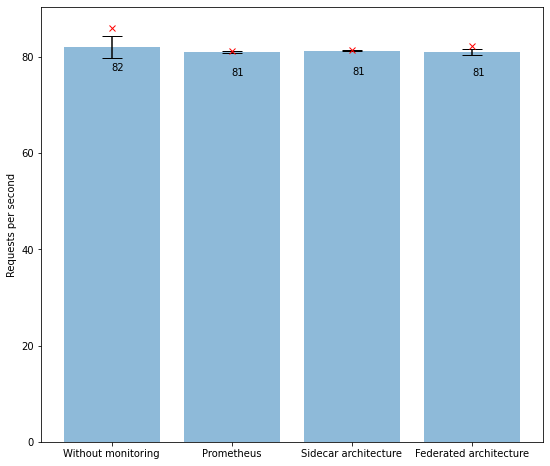

In [244]:
def barplot_2(df, mean_str, std_str, ylabel, spacing):   
    fig, ax = plt.subplots(figsize=(9,8))
    ax.bar(df.index, mean_str, yerr=std_str, alpha=0.5, data=df, capsize=10)
    for index, row in pd.DataFrame(df[mean_str]).iterrows():
        ax.text(index, row[mean_str] + spacing, round(row[mean_str]))
        
    for index, row in pd.DataFrame(df['max']).iterrows():
        ax.plot(index, row['max'], marker='x', color='r')
    plt.ylabel(ylabel)

barplot_2(load_test, 'mean', 'std', 'Requests per second', -5)


In [20]:
print((without_monitoring_load_test_requests_data.keys()))
print((with_prometheus_monitoring_load_test_requests_data.keys()))
print((sidecar_load_test_requests_data.keys()))
print((federated_load_test_requests_data.keys()))

dict_keys(['5', '4', '1', '2', '3'])
dict_keys(['3', '2', '1', '4', '5'])
dict_keys(['2', '3', '5', '1', '4'])
dict_keys(['2', '7', '3', '6', '5', '1', '4'])


In [177]:
at_rest_start = datetime(2022, 5, 19, 17, 25, 5)
at_rest_stop = datetime(2022, 5, 19, 17, 26, 5)
with_prometheus_monitoring_tx_bytes_at_rest_spiky = select_time_frame(with_prometheus_monitoring_tx_bytes, at_rest_start, at_rest_stop, False)


Text(0.5, 0, 'Time')

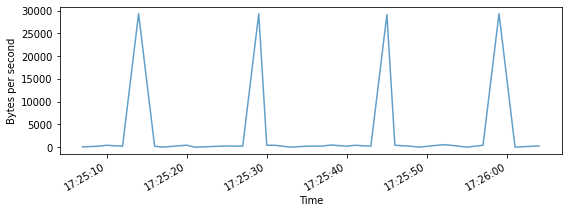

In [188]:
with_prometheus_monitoring_tx_bytes_at_rest_spiky[with_prometheus_monitoring_tx_bytes_at_rest_spiky.container_name=='k8s_POD_details-v1-994cb687f-czdps_without-monitoring_15375d17-456f-451c-8834-b79c1f153319_0'].plot('date', 'tx_bytes.mean_value', legend=False, figsize=(9,3), alpha=0.7)
plt.ylabel('Bytes per second')
plt.xlabel('Time')

In [150]:
with_prometheus_monitoring_tx_bytes

,date,container_name,tx_bytes.mean_value
0,2022-05-19 15:50:00,k8s_POD_productpage-v1-6c575bc5f7-2jgpl_withou...,415.0
1,2022-05-19 15:50:01,k8s_POD_reviews-v1-d9c7bcb7f-5h958_without-mon...,415.0
2,2022-05-19 15:50:02,k8s_POD_details-v1-994cb687f-czdps_without-mon...,481.0
3,2022-05-19 15:50:02,k8s_POD_productpage-v1-6c575bc5f7-2jgpl_withou...,0.0
4,2022-05-19 15:50:02,k8s_POD_reviews-v1-d9c7bcb7f-5h958_without-mon...,66.0
...,...,...,...
54104,2022-05-19 20:19:58,k8s_POD_reviews-v3-5b4bcdbdff-47qch_without-mo...,94616.5
54105,2022-05-19 20:19:59,k8s_POD_details-v1-994cb687f-czdps_without-mon...,48274.5
54106,2022-05-19 20:19:59,k8s_POD_productpage-v1-6c575bc5f7-2jgpl_withou...,565429.0
54107,2022-05-19 20:19:59,k8s_POD_reviews-v1-d9c7bcb7f-5h958_without-mon...,125849.0
